In [ ]:
library(tidyverse)

# Lab 4. Matched pairs analysis and Logistic regression

---

##McNemar’s Test for matched pairs
---

Consider having paired binary response data, for example the frequency of exposure to oral conjugated oestrogens among 183 cases of Endometrial cancer, and 183 age matched controls.

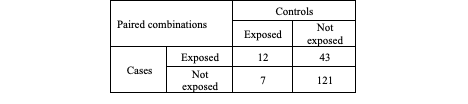

To test for significance of the association between disease and exposure you will need to use a different form of Chi-square test called McNemar’s test (with or without correction). Therefore, if we want to understand if there is evidence that exposure to oral conjugated oestrogens is a risk factor for Endometrial cancer and estimate the OR together with an approximate 95% CI, we will need to use the  command `mcnemar.text(x)` where `x` is a user-defined matrix.

In [ ]:
x<-matrix(c(12,7,43,121),2,2)
mcnemar.test(x)

**NOTE**: When writing the matrix, you will need to write by colums and not by rows, which means that your data must be ordered accordingly.

If we don’t want to have the continuity correction we need to write `correct=FALSE`

In [ ]:
mcnemar.test(x, correct=FALSE)

In this way we test for significance of the association between disease and exposure, but we don’t have any information about the OR and its CI, for that we will have to install and upload the package *exact2x2* and then use the command `mcnemar.exact`, or use the methods introduced in the previous labs.

In [ ]:
install.packages("exact2x2")
library(exact2x2)

In [ ]:
mcnemar.exact(x)

**Try to solve the other exercises in section 4.3 Matched Pairs of the lecture notes.**

##Logistic regression
---

### Import the data

Import the SPSS dataset “SPSS Logistic Regression 1.sav”

The data file contains the following five columns of data:

*   Subject   - an identification code from 1 to 500
*   Ethnicity   - coded  1 = White, 2 = Black, 3 = Other
*   Gender   -  coded 1 = Male and 2 = Female
*   Age   - subject age in years
*   Disease   - coded 1 = true (diseased), 0 = false (disease free)


View your data, summarise them and plot boxplots of diseased individuals depending on their age:

In [ ]:
library(haven)
MyData <- read_sav("SPSS Logistic Regression 1.sav")
head(MyData)

In [ ]:
summary(MyData)

In [ ]:
boxplot(Age~Disease,data=MyData)

In [ ]:
boxplot(Age~Disease,horizontal=TRUE,data=MyData)

In [ ]:
t.test(Age~Disease,data=MyData)

### Logistic regression with single numerical predictor

To perform the logistic regression, you will need to use the command `glm.fit` specifying *family=binomial*.  If we want to perform the logistic regression by considering the variable Age we will have to write

In [ ]:
glm.fit <- glm(Disease ~ Age, data = MyData, family = binomial(link='logit'))
summary(glm.fit)

How would you interpret the result?

#### Goodness of Fit

To check the goodness of fit (lack of fit) you will need to run a Hosmer-Lemeshow test. We can use the command `hoslem.test` in the library **ResourceSelection**

In [ ]:
install.packages("ResourceSelection")
library(ResourceSelection)

In [ ]:
hl<-hoslem.test(glm.fit$y, fitted(glm.fit), g=10)
hl

The HL test divides the sample of 500 individuals into g groups of approximately the same size. The observed number of events in each subgroup is compared to that predicted (expected) by the fitted model and tested for agreement using a chi-square test. We can visualise measured and expected values as follows:

In [ ]:
cbind(hl$observed,hl$expected)

#### Other methods for the goodness of fit

To learn about the overall (model) chi-square statistic and p-value we will either need to run an `ANOVA` on the model specifying chi-square as the test to use with the `ANOVA`.

In [ ]:
anova(glm.fit, test="Chisq")

or use the library **lmtest** and the command `lrtest` (search online (or ask `help`) for more details about this package and how this command works)

In [ ]:
install.packages("lmtest")
library(lmtest)

In [ ]:
help(lrtest)

In [ ]:
lrtest(glm.fit)

Another way to test the model is to compute its likelihood.  Usually it is more convenient to speak of the log-likelihood log(L), which is always negative. A larger log(L) means that L is closer to zero and therefore a better fit. We can calculate the log-likelihood using the command `logLik`:

In [ ]:
logLik(glm.fit)

or you can do calculate it yourself as follows:

In [ ]:
pi= fitted.values(glm.fit) 
likelihood = ifelse(MyData$Disease == 1, pi, 1 - pi)
log(prod(likelihood))

### Logistic regression with single categorical predictor

To run the logistic regression with the categorical variable Gender we first need to declare Gender as factor (otherwise R will interpret 1 and 2 as numbers). Our final aim is that R introduces dummy values for this variable. Let’s do that by using the function `as.factor` to create a new **Genderf** variable:

In [ ]:
MyData$Genderf = as.factor(MyData$Gender)

In [ ]:
# Stacked Bar Plot with Colors and Legend
counts <- table(MyData$Genderf,MyData$Disease)
barplot(counts, 
  xlab="Disease", col=c("darkblue","red"),
  legend = rownames(counts))

In [ ]:
levels(MyData$Genderf)

So Male is the reference category and female the exposure one. We want to make female the reference category, therefore we write:

In [ ]:
MyData$Genderf=relevel(MyData$Genderf,ref="2"); 

Let's check the levels again:

In [ ]:
levels(MyData$Genderf)

Run the logistic regression and check the goodness of fit with the new variable Genderf (What do you expect?).

In [ ]:
glm.fit <- glm(Disease ~ Genderf, data = MyData, family = binomial(link='logit'))
summary(glm.fit)

In [ ]:
hl<-hoslem.test(glm.fit$y, fitted(glm.fit), g=10)
hl

In [ ]:
cbind(hl$observed,hl$expected)

To understand how to change the order of the categories, look at the following page which. explains how R interprets factors: https://swcarpentry.github.io/r-novice-inflammation/12-supp-factors/

### Model Performance

One way of judging the performance of the model with regards to the discrimination between those with and without disease is to construct a classification table as follows:

In [ ]:
# predicted probabilities
Yhat <- fitted(glm.fit)

Choose a threshold for dichotomizing according to predicted probability

In [ ]:
thresh  <- 0.45
YhatFac <- cut(Yhat, breaks=c(-Inf, thresh, Inf), labels=c("No", "Yes"))

Create and visualise the contingency classfication table and add the marginal sums


In [ ]:
cTab <- table(MyData$Disease, YhatFac)
addmargins(cTab)

Calculate the percentage of total correct predictions

In [ ]:
# percentage correct total
sum(diag(cTab)) / sum(cTab)

Calculate the percentage of correct predictions of disease-free people

In [ ]:
# percentage correct disease-free
cTab[1,1]/sum(cTab[1,])

Calculate the percentage of correct predictions of people with the disease

In [ ]:
# percentage correct disease
cTab[2,2]/sum(cTab[2,])

#### Odds Ratio

Odds Ratio and Confidence Interval of the Odds Ratio are calculated as follows

In [ ]:
exp(coef(glm.fit))
exp(confint(glm.fit))

### Categorical predictors with more than two categories


If you are interested in understanding if a categorical factor with more than two categories is a predictor variable for the disease, you will need to
1. use a Chi-square test to understand if there is a significant association between ethnicity and disease;
2. decide which category you want to use as a reference or comparator group;
3. run the logistic regression.
In the specific case of our data we can use the variable ethnicity. Note that you will need to tell R that ethnicity is a factor.

In [ ]:
MyData$Ethnicity <- factor(MyData$Ethnicity)

Let’s check how many levels Ethnicity has and in which order they are set up.

In [ ]:
levels(MyData$Ethnicity)

Let’s now follow the steps for the analysis of the data as indicated above:
1. Run a Chi-square test (Find out how. Hint: you can cross-tabulate your data and then run the test, but there are also other ways).
2. As discussed during the lectures you can choose any of the three categories (white, black, other) as reference group as long as you justify why. Here we choose other – 3 (group with the highest risk) as reference group.

In [ ]:
MyData$Ethnicity=relevel(MyData$Ethnicity,ref="3"); 
levels(MyData$Ethnicity)

3. Run the logistic test and check the goodness of fit.

### Multivariate logistic regression. Logistic Regression using all predictors

Let’s now consider a model with age, gender and ethnicity present.
$$ \ln(Odds) = \beta_0+ \beta_1 * Age + \beta_2 * Male + \beta_3*E(1) + \beta_4 * E(2) $$
and let’s run the logistic regression in R as follows

In [ ]:
model.full = glm(Disease ~ Ethnicity+Genderf+Age, data=MyData, family = binomial(link="logit"))


Answer the following questions
1. What are the values of the coefficients?
2. The odds ratio for male gender, adjusting for age and ethnicity?
3. The odds ratio for age, adjusting for gender and ethnicity?
4. The odds ratio for ethnicity, adjusting for gender and age?
5. Compare the adjusted odds ratios with the odds ratios you calculated with the univariate models (crude).
6. Do your results agree with the ones in the lecture notes (M342 5.2)?

## How to visualise the logistic regression

In this section we are going to see an illustrative example of how the logistic curve fits through the data. Let’s run the logistic regression with age and gender only:

In [ ]:
logm = glm(Disease ~ Age + Gender, data=MyData, family=binomial) 
summary(logm)

Let’s now plot the model against the data

In [ ]:
install.packages("mosaic")
library(mosaic)

In [ ]:
myplot = xyplot(jitter(Disease) ~ Age, groups=Gender, data=MyData, alpha=0.5, pch=19, cex=2, ylab="Disease") 
fit.outcome = makeFun(logm) 
plotFun(fit.outcome(Age=x, Gender=1) ~ x, lwd=3, plot=myplot, add=TRUE)

The following commands allow to plot two (or more) lines in the same figure

In [ ]:
cols = trellis.par.get()$superpose.symbol$col 
plotFun(fit.outcome(Age=x, Gender=2) ~ x, col=cols[2], lwd=3, add=TRUE)

When we plot in this way it is difficult to see the goodness of the fit. For this reason, let’s divide the sample into ten age groups (as in the lecture notes), and let’s ask for some basic statistics of the data.

In [ ]:
MyData=MyData %>% 
mutate(ageGroup = cut(Age, breaks=10)) 
favstats(~Disease | ageGroup, data=MyData)

We are now going to fit the results of the regression to the data arranged in groups:

In [ ]:
binned.y = mean(~Disease | ageGroup, data=MyData)
binned.x = mean(~Age | ageGroup, data=MyData)
binplot = xyplot(binned.y ~ binned.x, cex=2, pch=19, col="orange", lwd=3)
plotFun(fit.outcome(Age=x, Gender=1) ~ x, lwd=3, add=TRUE, plot=binplot)
plotFun(fit.outcome(Age=x, Gender=2) ~ x, col=cols[2], lwd=3, add=TRUE)

You should have got the following plot:

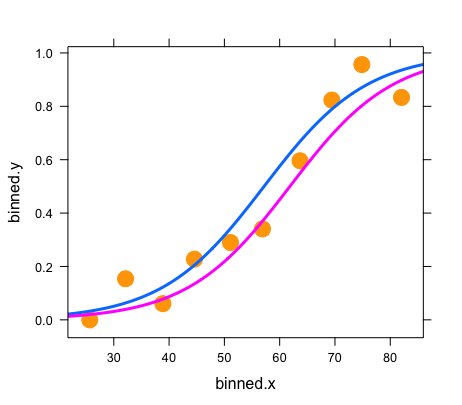

# You now have all tools you need to solve the following exercises.

## Exercises

### Exercise 1

Import the Titanic data set. The aim of this exercise is to identify factors associated with survival as opposed to death or disease.

The four variables in the data set to be used are:

pclass = passenger class, a string variable with values 1st, 2nd or 3rd 

age =  age of passenger in years,

sex = gender, a string variable with values male or female.

survival status, coded 1 = survived and 0 = died


Fit a logistic regression model predicting survival on the Titanic from the age of the passenger. 

Write down the equation of the logistic model:

$$\ln(Odds) = $$

What is the Odds Ratio for age? Interpret the value obtained.

OR (CI) =

Interpretation



What is the overall (model) chi-square statistic and p – value? 

Chi – square = 
  $\qquad \qquad \qquad \qquad$                p – value = 

Is age a significant predictor of survival? Yes /No

What is the test statistic for the Hosmer-Lemeshow test and corresponding p – value?

Chi – square = 
  $\qquad \qquad \qquad \qquad$                p – value = 

Does the fitted model provide an adequate fit to the data? Yes / No

> Fit a logistic regression model predicting survival on the Titanic from both age and gender. Use female as reference group.



Write down the equation of the logistic model:

$$\ln(Odds) = $$

What is the overall (model) chi-square statistic and p – value?

Chi – square = 
  $\qquad \qquad \qquad \qquad$                p – value = 

What is the test statistic for the Hosmer Lemeshow test and corresponding p – value?

Chi – square = 
  $\qquad \qquad \qquad \qquad$                p – value = 

Does the fitted model provide an adequate fit to the data? Yes / No

Complete the table of “adjusted” Odds ratios from the “full” model.

|Predictor	| Crude OR | Crude p-value |	Adjusted OR|  Adjusted p-value|
|-----------|-----------|-----------|-----------|-----------|
|Passenger age|	0.991 |	0.093 |     |      |		
|   Gender    |     |    		|   |   |		
|Female | 	9.986 |	< 0.001 |   |   |  		
|Male |	1.0 |	-	| 1.0 |	- |

Is there evidence of confounding? Yes / No

Can you think of why the fitted model may not fit too well?

### Exercise 2

Open the file “SPSS Logistic regression 2 – MDM data”

**Background to the data**

Duchenne Muscular Dystrophy, DMD, is a genetically transmitted disease, passed from a mother to her children. Affected female offspring usually suffer no apparent symptoms and may unknowingly carry the disease. Male offspring with the disease die at a young age. A detection problem occurs when, for example, a woman suspects that she may be a carrier, possibly as a result of and affected male child in her extended family. Although carriers of DMD have no physical symptoms, they tend to exhibit elevated levels of certain serum enzymes or proteins, such as creatine kinase (CK), hemopexin (H), lactate dehydroginase (LD) and pyruvate kinase (PK). The first two serum markers (CK and H) may be measured relatively inexpensively from frozen serum. The second two (PK and LD) require fresh serum. The levels of these enzymes may also depend upon age. 

The data file contains information for 82 women of whom 35 are known carriers of DMD. 
Note that for some of the variables data is missing.  

1. Begin by fitting a logistic regression model predicting MDM from CK (Creatine Kinase) alone. 

2. Request the Hosmer – Lemeshow GOF test and save the predicted probabilities to the worksheet. Repeat the exercise using each variable, one at a time.

3. Fitted model:  Ln(Odds) = 

  a. Use the fitted model to calculate the p(MDM) for a subject with CK = 35. Prob = ________

  b. Use the fitted model to calculate the p(MDM) for a subject with CK = 50. Prob = ________

  c. Does the “Omnibus chi-square” statistic indicate CK is a significant predictor of disease?  Y/N

  d. Does the Hosmer – Lemshow goodness of fit test indicate an adequate model?   Y/N 

  e. What is the overall accuracy in disease classification using CK alone?  _________

|Predictor variable |	Fitted model  $$Ln(Odds)$$ |	Anova $\chi^2$   $$\text{p - value}$$ |	Hosmer-Lemshow $$\text{GOF (p - value)}$$ |	Overall Accuracy (%) |
|----|---|---|---|---|
|1 = CK	| | | |			
|2 = H	| | | |				
|3 = LD	| | | |				
|4 = PK	| | | |		

### Exercise 3

The data set GVHD.sav records the presence or absence of graft versus host disease (GVHD) in 37 patients receiving a non-depleted allogeneic bone marrow transplant. The variables are:

*  	Rage -  age the age of recipient 
*  	Dage - age the age of  donor, 
*  	Type - type of leukaemia,  1 = acute myeloid, 2 = acute lymphocytic, 3 = chronic myeloid 
*  	Preg - whether or not the donor had been pregnant (No = 0, Yes = 1), 
*  	Index - index of mixed epidermal cell-lymphocyte reactions.
*  	GVHD - presence or absence of graft versus host disease

1.	Fit a logistic regression model using recipient age as a single predictor of GVHD. What is the OR for this predictor? Interpret your result.

2.	Fit a logistic regression model using Leukaemia type as a single predictor. What are the ORs for this categorical predictor? Interpret your result.

3.	Fit a logistic regression model using recipient Index of . .  as a single predictor. What is the OR for this predictor? Interpret your result.

4.	Fit a multiple logistic regression model with all three predictors and record the corresponding “adjusted” Odds Ratios.

|Predictor |	Univariate (Crude) OR | Crude p-value|	Multivariate (Adjusted) OR| Adjusted p-value|
|---|---|---|---|---|
|Recipient age|  |  |  |  |	
|Leukaemia type|  |  |  |  |	
|1 = acute myeloid|  |  |  |  |	
|2 = acute lymphocytic|  |  |  |  |	
|3 = chronic myeloid|  |  |  |  |	
|Index of mixed…	|  |  |  |  |	
 
5.	Is the overall 3-predictor model significant?                                       

6.	Does the Hosmer-Lemeshow test indicate a poor fit?                                           

7.	Which predictors appear significant after adjusting for other variables? 